In [63]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.backend import clear_session
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from tqdm import tqdm
from numpy.random import seed
import tensorflow as tf
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

## Parameter

In [27]:
#Data Parameters
num_of_classes = 4
data_shape = (7,1)

#MLP Parameters
times_to_run = 50 #Number of times to run MLP model
mlp_epochs = 40
valid_split = 0.20

#GAN Parameters
latent_dim = 100
gan_epochs = 5000

#Random Seeds
selection_seed = 150
seed_multiplier = 1000000

In [28]:
#一个图形化界面
cb1 = widgets.Checkbox(description="Generate missing data only")
slider1 = widgets.FloatSlider(value=0.1, min=0.05, max=1, step=0.05)
slider2 = widgets.IntSlider(value=250, min=0, max=1000, step=250)
vb = widgets.VBox(children = [slider2])
def checkbox(button):
    if button['new']:
        vb.children = []
        slider2.value = 250 - int(slider1.value*250) 
    else:
        vb.children = [slider2]
        experiment3 = False
cb1.observe(checkbox, names='value')

print("Percentage of Real Data:")
display(slider1)
print("Number of datapoints GAN generates:")
display(vb)
display(cb1)

Percentage of Real Data:


FloatSlider(value=0.1, max=1.0, min=0.05, step=0.05)

Number of datapoints GAN generates:


Checkbox(value=False, description='Generate missing data only')

In [49]:
fraction_of_data = slider1.value
data_to_gen = slider2.value

## Data preprocessing

In [30]:
dataset = pd.read_csv("./data/dataset.csv")
labels = dataset.Class.values
labels = labels - 1 #Original label values are from 1 to 4
features = dataset.drop(columns='Class').values
features

array([[-64, -56, -61, ..., -71, -82, -81],
       [-68, -57, -61, ..., -71, -85, -85],
       [-63, -60, -60, ..., -76, -85, -84],
       ...,
       [-62, -59, -46, ..., -45, -87, -88],
       [-62, -58, -52, ..., -41, -90, -85],
       [-59, -50, -45, ..., -45, -88, -87]], dtype=int64)

In [31]:
tr_fea, X_test, tr_label, Y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.5,
                                                    random_state= selection_seed,
                                                    #random_state：可以理解为随机数种子，主要是为了复现结果而设置
                                                    stratify=labels)
tr_fea.shape[0], X_test, tr_label, Y_test

(1000,
 array([[-64, -58, -51, ..., -40, -88, -87],
        [-59, -52, -49, ..., -56, -83, -81],
        [-41, -58, -54, ..., -71, -65, -71],
        ...,
        [-63, -53, -47, ..., -46, -90, -81],
        [-52, -53, -56, ..., -62, -83, -80],
        [-40, -50, -52, ..., -68, -73, -71]], dtype=int64),
 array([3, 3, 0, 1, 1, 1, 3, 0, 2, 1, 1, 0, 2, 2, 3, 2, 1, 3, 0, 1, 3, 0,
        0, 0, 3, 0, 3, 3, 3, 2, 2, 0, 3, 1, 2, 1, 0, 1, 1, 0, 3, 1, 3, 1,
        1, 0, 1, 0, 3, 3, 3, 0, 3, 0, 1, 2, 0, 1, 2, 0, 1, 3, 3, 2, 0, 2,
        0, 1, 2, 2, 0, 0, 0, 0, 1, 3, 2, 0, 3, 1, 3, 1, 3, 2, 0, 2, 2, 1,
        1, 0, 0, 0, 1, 1, 2, 1, 1, 2, 1, 3, 3, 1, 2, 2, 3, 1, 3, 0, 1, 2,
        3, 3, 3, 1, 0, 3, 1, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 2, 0, 1, 1, 2,
        2, 1, 2, 2, 0, 2, 1, 1, 3, 2, 1, 0, 2, 0, 0, 2, 1, 2, 0, 2, 3, 1,
        3, 1, 3, 2, 0, 3, 1, 1, 0, 3, 2, 2, 2, 0, 2, 0, 0, 3, 3, 3, 0, 3,
        2, 1, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 0, 3, 3, 2, 3, 2,
        2, 1, 2, 2, 2, 2, 3, 

In [39]:
X_train = []
Z_train = [] #This is the same as X_train, but it's used for training the GAN
Y_train = []

for idx in range(4):
    number_filter = np.where(tr_label == idx)
    X_filtered, Y_filtered = tr_fea[number_filter], tr_label[number_filter]

    num_of_data = (int)(fraction_of_data*X_filtered.shape[0])
    RandIndex = np.random.choice(X_filtered.shape[0], 
                                 num_of_data, 
                                 replace=False)
    Z_train.append(X_filtered[RandIndex])#append添加是将容器看作整体来进行添加，但extend是将容器打碎后添加（加入的只是元素）
    X_train.extend(X_filtered[RandIndex])
    Y_train.extend(Y_filtered[RandIndex])
# X_train,Z_train
X_train = np.asarray(X_train, dtype=np.float32)
Y_train = np.asarray(Y_train, dtype=np.float32)
# X_train
#random.shuffle只能对一维list和两维list进行数据打乱
#numpy.random.shuffle可以对列表和数组进行数据打乱
#from sklearn.utils import shuffle中的shuffle可以直接打乱
X_train, Y_train = shuffle(X_train, Y_train)

#将类别向量映射为二值类别矩阵, 用于应用到以categorical_crossentropy为目标函数的模型中.
Y_train_encoded = to_categorical(Y_train)
Y_test_encoded = to_categorical(Y_test)

In [40]:
#Data must be standized using standard scaler before using the MLP.
scaler = StandardScaler()  #from sklearn.preprocessing import StandardScaler
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.fit_transform(X_test)
X_train_transformed

array([[-0.78983855, -0.89725935, -0.22361736, -0.960994  ,  1.3686215 ,
        -0.45724323, -0.80537343],
       [-1.26223   , -0.89725935,  1.9153315 , -1.2461555 ,  1.1561025 ,
        -1.5793126 , -1.5270342 ],
       [-0.5064037 ,  0.6286919 ,  1.7208816 , -0.10550974,  1.3686215 ,
        -0.7377606 , -1.382702  ],
       [-0.600882  ,  0.32350165,  1.3319817 , -0.485725  ,  1.793659  ,
        -0.59750193, -0.22804481],
       [ 0.343901  , -0.5920691 , -0.02916748,  0.1796517 ,  0.30602714,
        -0.17672591, -0.37237695],
       [ 0.4383793 , -1.5076399 , -0.41806728,  0.27470553, -0.4377888 ,
        -0.17672591,  0.78228027],
       [ 1.0052491 ,  0.9338822 ,  0.9430819 ,  0.94008225, -0.8628265 ,
         1.927154  ,  2.5142663 ],
       [ 0.1549444 , -2.1180203 ,  0.748632  ,  0.1796517 , -0.3315294 ,
         0.38430873, -1.0940378 ],
       [-0.8843168 , -0.28687882, -1.0014169 , -1.0560478 , -0.96908593,
        -0.17672591, -0.80537343],
       [-0.5064037 ,  0.3235

## Classification with MLP for Real Data

In [41]:
all_test_loss =[]
all_test_acc = []
history = []

for i in tqdm_notebook(range(times_to_run)):
    seed(i*seed_multiplier)#操作级
    tf.random.set_seed(i*seed_multiplier)#图级
    model = Sequential()
    model.add(Dense(128, input_shape=(7,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(0.0002, 0.5),#learning rate, the exponential decay rate for the 1st moment estimates
                                              # 学习率      , 一阶矩估计的指数衰减率
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history_temp = model.fit(X_train_transformed,
                            Y_train_encoded,
                            epochs=mlp_epochs,
                            batch_size=64,
                            validation_split=valid_split,
                            verbose=0)
    history.append(history_temp)
    test_loss, test_acc = model.evaluate(X_test_transformed, 
                                         Y_test_encoded, 
                                         verbose=0)

    all_test_acc.append(test_acc)
    all_test_loss.append(test_loss)
    del(model)
    clear_session()

C:\Users\xfp\AppData\Local\Temp\ipykernel_15352\3616858317.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(times_to_run)):


  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Training and validation loss for 50.0%')

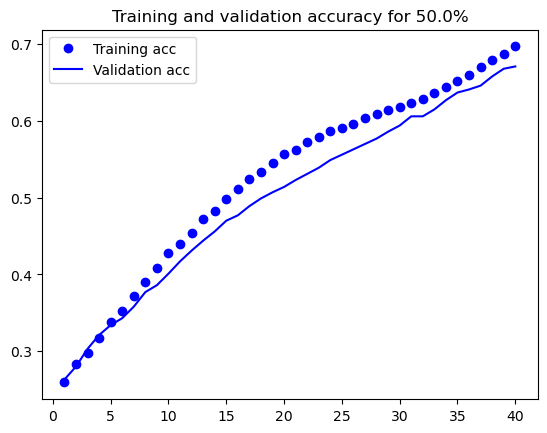

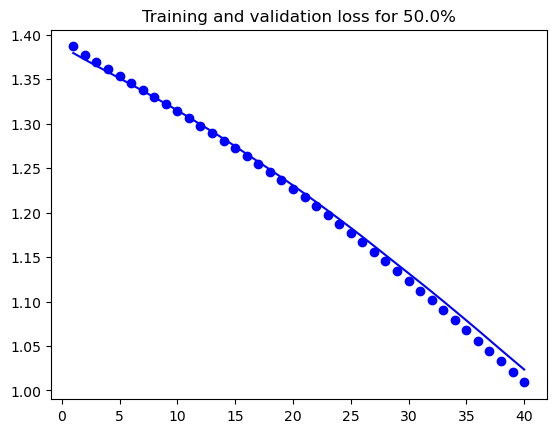

In [50]:
trainacc = []
trainloss = []
valacc = []
valloss = []
for i in range (len(history)):
    trainacc.append(history[i].history['accuracy'])
    trainloss.append(history[i].history['loss'])
    valacc.append(history[i].history['val_accuracy'])
    valloss.append(history[i].history['val_loss'])

acc = np.mean(trainacc, axis=0)
val_acc = np.mean(valacc, axis=0)
loss = np.mean(trainloss, axis=0)
val_loss = np.mean(valloss, axis=0)
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy for {}%'.format(fraction_of_data*100))
plt.legend()#作用是加上图例，很有必要
plt.figure()#创建新图
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for {}%'.format(fraction_of_data*100))
# plt.legend()
# plt.savefig("./results/original/Train - {}%.png".format(fraction_of_data*100))

## Generating Synthetic Data

In [64]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))#经典值为0.9
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(data_shape), activation='tanh'))
    model.add(Reshape(data_shape))

#     model.summary()

    noise = Input(shape=(latent_dim,))
    gendata = model(noise)
    
    return Model(noise, gendata) #keras.models.Model(input,output) 模型起始输入和最终输出 #Sequential()继承于Model

In [65]:
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=data_shape))#keras.layers.Flatten将数据压成一维的
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))#二分类一般使用sigmoid 和softmax

    #model.summary()

    data = Input(shape=data_shape)
    validity = model(data)

    return Model(data, validity)

In [70]:
def train(epochs, features, batch_size):

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
            idx = np.random.randint(0, features.shape[0], batch_size)
            data = features[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_data = generator.predict(noise) #generator

            d_loss_real = discriminator.train_on_batch(data, valid)
            d_loss_fake = discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #损失函数应该还可以改进

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = combined.train_on_batch(noise, valid) #combined

## Training GAN

In [74]:
gen_data = []

for i in tqdm(range(num_of_classes)):
    discriminator = build_discriminator()
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=Adam(0.0002, 0.5),
                          metrics=['accuracy'])
    
    generator = build_generator()
    noise = Input(shape=(latent_dim,))
    gendata = generator(noise)
    discriminator.trainable = False#禁用了判别器的参数更新
    validity = discriminator(gendata)
    combined = Model(noise, validity)#连接生成器和判别器
    combined.compile(loss='binary_crossentropy',
                    optimizer=Adam(0.0002, 0.5))

    minimaxscaler = MinMaxScaler((-1,1))#归一化到（-1，1）之间 #from sklearn.preprocessing import MinMaxScaler
    Z_train_transformed = minimaxscaler.fit_transform(Z_train[i])
    Z_train_transformed = np.expand_dims(Z_train_transformed, axis=2)#扩充维度（*，*，1）

    train(epochs=gan_epochs,
          features=Z_train_transformed,
          batch_size=128)
        
    noise = np.random.normal(0, 1, (data_to_gen, latent_dim))
    gen_data_temp = generator.predict(noise)
    gen_data_temp = np.asarray(gen_data_temp, dtype=np.float32)
    gen_data_temp = np.squeeze(gen_data_temp)#删除维度为1 #（1，2，5）==> （2，5）
    gen_data_temp = minimaxscaler.inverse_transform(gen_data_temp) #将归一化数据转回来

    gen_data.append(gen_data_temp)

    clear_session()
    #在每折的开头都需要加上clear_session()。否则上一折的训练集成了这一折的验证集，数据泄露。
    #同时，不清空的话，那么graph上的node越来越多，内存问题，时间问题都会变得严峻。
    #可以有效解决模型的内存占用问题
    del(discriminator)
    del(generator)
    del(combined)

gen_data = np.asarray(gen_data, dtype=np.float32)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 538us/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 2ms/step


 25%|████████████████████▊                                                              | 1/4 [06:45<20:16, 405.37s/it]

4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


 50%|█████████████████████████████████████████▌                                         | 2/4 [13:36<13:37, 408.56s/it]

4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 0s/step


8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [20:33<06:52, 412.55s/it]

4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 0s/step


4/4 [==============================] - 0s 5ms/step


8/8 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [27:33<00:00, 413.46s/it]


## Classification with MLP for Real + Synthetic Data

### Preprocess synthetic data

In [83]:
gen_label = []
for i in range(4):
    gen_label_temp = np.tile(i, data_to_gen)
    gen_label.extend(gen_label_temp)

gen_label = np.asarray(gen_label, dtype=np.float32)
gen_label_encoded = to_categorical(gen_label)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [87]:
gen_data_reshaped = gen_data.reshape(num_of_classes*data_to_gen, data_shape[0])
X_train_gan, Y_train_gan = shuffle(gen_data_reshaped,
                                   gen_label_encoded, 
                                   random_state=5)

In [88]:
new_x_train = np.concatenate((X_train, X_train_gan), axis=0)
new_y_train = np.concatenate((Y_train_encoded, Y_train_gan), axis=0)

new_x_train, new_y_train = shuffle(new_x_train, new_y_train, random_state=15)
new_x_train_transformed = scaler.fit_transform(new_x_train)

### Train a new MLP on Real+Synthetic Data

In [90]:
all_test_loss_gan =[]
all_test_acc_gan = []
ganhistory = []

for i in tqdm_notebook(range(times_to_run)):
    seed(i*seed_multiplier)
    tf.random.set_seed(i*seed_multiplier)

    model = Sequential()
    model.add(Dense(128, input_shape=(7,), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(0.0002, 0.5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    ganhistorytemp = model.fit(new_x_train_transformed,
                    new_y_train,
                    epochs=mlp_epochs,
                    batch_size=64,
                    validation_split=valid_split,
                    verbose = 0)
    ganhistory.append(ganhistorytemp)

    test_loss, test_acc = model.evaluate(X_test_transformed, 
                                         Y_test_encoded, 
                                         verbose=0)
    print("#{} Test acc:".format(i), test_acc)

    all_test_acc_gan.append(test_acc)
    all_test_loss_gan.append(test_loss)
    del(model)
    clear_session()

C:\Users\xfp\AppData\Local\Temp\ipykernel_15352\1082841554.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(times_to_run)):


  0%|          | 0/50 [00:00<?, ?it/s]

#0 Test acc: 0.9480000138282776
#1 Test acc: 0.9570000171661377
#2 Test acc: 0.9490000009536743
#3 Test acc: 0.9390000104904175
#4 Test acc: 0.9470000267028809
#5 Test acc: 0.9570000171661377
#6 Test acc: 0.9330000281333923
#7 Test acc: 0.9480000138282776
#8 Test acc: 0.9480000138282776
#9 Test acc: 0.9509999752044678
#10 Test acc: 0.9419999718666077
#11 Test acc: 0.9480000138282776
#12 Test acc: 0.9580000042915344
#13 Test acc: 0.9229999780654907
#14 Test acc: 0.9509999752044678
#15 Test acc: 0.9359999895095825
#16 Test acc: 0.9459999799728394
#17 Test acc: 0.9390000104904175
#18 Test acc: 0.9509999752044678
#19 Test acc: 0.9449999928474426
#20 Test acc: 0.9559999704360962
#21 Test acc: 0.8970000147819519
#22 Test acc: 0.9589999914169312
#23 Test acc: 0.9449999928474426
#24 Test acc: 0.9470000267028809
#25 Test acc: 0.9390000104904175
#26 Test acc: 0.953000009059906
#27 Test acc: 0.9319999814033508
#28 Test acc: 0.921999990940094
#29 Test acc: 0.9300000071525574
#30 Test acc: 0.953000

## Save Results

In [92]:
AccMean = np.mean(all_test_acc)
LossMean = np.mean(all_test_loss)
AccStd = np.std(all_test_acc)
LossStd = np.std(all_test_loss)

GanAccMean = np.mean(all_test_acc_gan)
GanLossMean = np.mean(all_test_loss_gan)
GanAccStd = np.std(all_test_acc_gan)
GanLossStd = np.std(all_test_loss_gan)

lines  = list()
lines.append("Original Data (Each Class: {} Real):".format(num_of_data))
lines.append("Accuracy mean: {}".format(AccMean))
lines.append("Loss mean: {}".format(LossMean))
lines.append("Accuracy STD: {}".format(AccStd))
lines.append("Loss STD: {} \n".format(LossStd))
lines.append("Maximum Accuracy: {}".format(np.max(all_test_acc)))
lines.append("Loss of Maximum Accuracy: {}".format(
    all_test_loss[np.argmax(all_test_acc)]))

lines.append("\n ================== \n")
lines.append("Original + GAN Data" +
             "(Each Class: {} Real + {} GAN):".format(num_of_data, 
                                                      data_to_gen))
lines.append("Accuracy mean: {}".format(GanAccMean))
lines.append("Loss mean: {}".format(GanLossMean))
lines.append("Accuracy STD: {}".format(GanAccStd))
lines.append("Loss STD: {} \n".format(GanLossStd))
lines.append("Maximum Accuracy: {}".format(np.max(all_test_acc_gan)))
lines.append("Loss of Maximum Accuracy: {}".format(
    all_test_loss_gan[np.argmax(all_test_acc_gan)]))


file_dir = "./test - {}%.txt".format(fraction_of_data*100)
with open(file_dir, "w") as filehandle:
    for items in lines:
        filehandle.write('%s\n' % items)